## Ellis Analysis Notebook

In this notebook, we want to examine what neighborhood factors could have impacted the use of the Ellis Act. We are now going to use another assessor's dataset from 2019, and concern ourselves with the period of 2014-2019 in particuar in order to study the determinants of the Ellis Act on the property level during this period of intensive use.

Datasets:

* Ellis Act Filing Records 2007- Present (May 2021): https://hcidla2.lacity.org/ELLIS - base dataset, now joined, see previous notebook - we will be extracting data from years 2015-2019 for this study. 

* Census tract level demographic and econmoic data: ACS 5 Years 2014 and 2019 from census api through cenpy. Index of tables https://www2.census.gov/programs-surveys/acs/tech_docs/table_shells/2019/: data for Los Angeles County Census Tracts.

* Los Angeles County Assessors Parcel Records (2019): Purchased by SAJE, used with permissions - used to identify parcel status, features and ownership - GEOJSON export including selected columns for LA city parcels from SAJE owned geopackage.

In [1]:
#Import modules: pandas/geopandas
import pandas as pd
import geopandas as gpd

Next, we import our cleaned dataset from our first notebook, ellis_joined. The preceding notebook details the cleaning and joining process. This dataset includes all Ellis Act filings in the City of LA from 2007 to May 2021 (the original dataset includes all of LA County, but we only exported the LA City data). 

In [2]:
ellisdf=pd.read_csv('/Users/alexanderferrer/Documents/GitHub/UP229_Ellis/ellis_joined.csv')

ellisdf.head()

,Unnamed: 0,application_received,application_year,council_district,address,city,zip,units_withdrawn,replacement_unit,yearbuilt,units,sqftmain,center_lat,center_lon,geometry
0,2040031029,11/6/19,2019,3,22729 W DEL VALLE ST,LOS ANGELES,91364.0,3,0.0,1955.0,3.0,1860.0,34.165880,-118.621319,POINT (-13204864.81828771 4051097.450097568)
1,2040031030,12/4/19,2019,3,22727 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,1869.0,34.165929,-118.621164,POINT (-13204847.61386041 4051104.006178072)
2,2040033033,2/10/16,2016,3,22431 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,1869.0,34.167389,-118.616525,POINT (-13204331.1860447 4051300.523521864)
3,2107014004,4/21/20,2020,3,20327 W STAGG ST,LOS ANGELES,91306.0,3,0.0,1910.0,3.0,2446.0,34.211389,-118.576350,POINT (-13199858.95667153 4057221.803746735)
4,2111025021,3/16/16,2016,3,7118 N JORDAN AVE,CANOGA PARK,91303.0,2,9.0,1947.0,2.0,1489.0,34.199760,-118.602505,POINT (-13202770.5034817 4055656.567431433)


In [3]:
ellisdf.rename(columns={'Unnamed: 0': 'ain',}, inplace=True)

ellisdf.head()

,ain,application_received,application_year,council_district,address,city,zip,units_withdrawn,replacement_unit,yearbuilt,units,sqftmain,center_lat,center_lon,geometry
0,2040031029,11/6/19,2019,3,22729 W DEL VALLE ST,LOS ANGELES,91364.0,3,0.0,1955.0,3.0,1860.0,34.165880,-118.621319,POINT (-13204864.81828771 4051097.450097568)
1,2040031030,12/4/19,2019,3,22727 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,1869.0,34.165929,-118.621164,POINT (-13204847.61386041 4051104.006178072)
2,2040033033,2/10/16,2016,3,22431 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,1869.0,34.167389,-118.616525,POINT (-13204331.1860447 4051300.523521864)
3,2107014004,4/21/20,2020,3,20327 W STAGG ST,LOS ANGELES,91306.0,3,0.0,1910.0,3.0,2446.0,34.211389,-118.576350,POINT (-13199858.95667153 4057221.803746735)
4,2111025021,3/16/16,2016,3,7118 N JORDAN AVE,CANOGA PARK,91303.0,2,9.0,1947.0,2.0,1489.0,34.199760,-118.602505,POINT (-13202770.5034817 4055656.567431433)


In [4]:
ellisdf['application_date'] = pd.to_datetime(ellisdf['application_received'])

print(ellisdf['application_date'].unique())

['2019-11-06T00:00:00.000000000' '2019-12-04T00:00:00.000000000'
 '2016-02-10T00:00:00.000000000' ... '2020-07-20T00:00:00.000000000'
 '2018-02-13T00:00:00.000000000' '2017-01-12T00:00:00.000000000']


In this case we are only interested in Ellis Act Evictions from 2014 to 2019, so we will create a new dataset dropping the others.

In [5]:
studyellisdf=ellisdf[ellisdf['application_year'].between(2015, 2019)]

print(studyellisdf['application_year'].unique())

[2019 2016 2015 2018 2017]


Next, we import our assessor data from 2019. This gives us information about characteristics of each parcel in 2019, such as the year it was built, who owns it, and so on.

In [7]:
parcelsdf=pd.read_csv('/Users/alexanderferrer/Desktop/assessor_2019_la.csv')

parcelsdf.columns

/Applications/anaconda3/envs/UP299/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['fid', 'CENTER_LON', 'YearBuilt5', 'YearBuilt4', 'YearBuilt1',
       'UseType', 'YearBuilt2', 'APN', 'Bedrooms1', 'Bedrooms2', 'Bedrooms3',
       'Bedrooms4', 'Bedrooms5', 'UseDescription', 'MailAddress', 'SQFTmain2',
       'SQFTmain3', 'SQFTmain1', 'SQFTmain4', 'SQFTmain5', 'MailCity',
       'Units1', 'Units3', 'Units2', 'Units5', 'Units4', 'OwnerFullName',
       'AgencyName', 'AIN', 'Bathrooms5', 'Bathrooms4', 'Bathrooms1',
       'Bathrooms3', 'Bathrooms2', 'SitusFullAddress', 'Shape.STArea()',
       'Shape.STLength()', 'YearBuilt3', 'CENTER_LAT', 'LS1 Sale Amount',
       'LS1 Sale Date', 'LS2 Sale Amount', 'LS2 Sale Date'],
      dtype='object')

In [8]:
parcelsdf.columns=parcelsdf.columns.str.lower()

parcelsdf.columns

Index(['fid', 'center_lon', 'yearbuilt5', 'yearbuilt4', 'yearbuilt1',
       'usetype', 'yearbuilt2', 'apn', 'bedrooms1', 'bedrooms2', 'bedrooms3',
       'bedrooms4', 'bedrooms5', 'usedescription', 'mailaddress', 'sqftmain2',
       'sqftmain3', 'sqftmain1', 'sqftmain4', 'sqftmain5', 'mailcity',
       'units1', 'units3', 'units2', 'units5', 'units4', 'ownerfullname',
       'agencyname', 'ain', 'bathrooms5', 'bathrooms4', 'bathrooms1',
       'bathrooms3', 'bathrooms2', 'situsfulladdress', 'shape.starea()',
       'shape.stlength()', 'yearbuilt3', 'center_lat', 'ls1 sale amount',
       'ls1 sale date', 'ls2 sale amount', 'ls2 sale date'],
      dtype='object')

In [9]:
parcelsdf.columns = parcelsdf.columns.str.replace(' ','_')

parcelsdf.columns

Index(['fid', 'center_lon', 'yearbuilt5', 'yearbuilt4', 'yearbuilt1',
       'usetype', 'yearbuilt2', 'apn', 'bedrooms1', 'bedrooms2', 'bedrooms3',
       'bedrooms4', 'bedrooms5', 'usedescription', 'mailaddress', 'sqftmain2',
       'sqftmain3', 'sqftmain1', 'sqftmain4', 'sqftmain5', 'mailcity',
       'units1', 'units3', 'units2', 'units5', 'units4', 'ownerfullname',
       'agencyname', 'ain', 'bathrooms5', 'bathrooms4', 'bathrooms1',
       'bathrooms3', 'bathrooms2', 'situsfulladdress', 'shape.starea()',
       'shape.stlength()', 'yearbuilt3', 'center_lat', 'ls1_sale_amount',
       'ls1_sale_date', 'ls2_sale_amount', 'ls2_sale_date'],
      dtype='object')

We need to find total values for the parcels' characteristics, so first we need to convert the fields to in and nulls to zeros.

In [10]:
parcelsdf[['bedrooms1', 'bedrooms2', 'bedrooms3','bedrooms4', 'bedrooms5','sqftmain2','sqftmain3','sqftmain1', 'sqftmain4', 'sqftmain5','units1', 'units3', 'units2', 'units5', 'units4','bathrooms5', 'bathrooms4', 'bathrooms1','bathrooms3', 'bathrooms2']]= parcelsdf[['bedrooms1', 'bedrooms2', 'bedrooms3','bedrooms4', 'bedrooms5','sqftmain2','sqftmain3','sqftmain1', 'sqftmain4', 'sqftmain5','units1', 'units3', 'units2', 'units5', 'units4','bathrooms5', 'bathrooms4', 'bathrooms1','bathrooms3', 'bathrooms2']].fillna(0)

In [11]:
parcelsdf[['bedrooms1', 'bedrooms2', 'bedrooms3','bedrooms4', 'bedrooms5','sqftmain2','sqftmain3','sqftmain1', 'sqftmain4', 'sqftmain5','units1', 'units3', 'units2', 'units5', 'units4','bathrooms5', 'bathrooms4', 'bathrooms1','bathrooms3', 'bathrooms2']]= parcelsdf[['bedrooms1', 'bedrooms2', 'bedrooms3','bedrooms4', 'bedrooms5','sqftmain2','sqftmain3','sqftmain1', 'sqftmain4', 'sqftmain5','units1', 'units3', 'units2', 'units5', 'units4','bathrooms5', 'bathrooms4', 'bathrooms1','bathrooms3', 'bathrooms2']].astype(int)

In [12]:
parcelsdf['units_total']=parcelsdf['units1']+parcelsdf['units2']+parcelsdf['units3']+parcelsdf['units4']+parcelsdf['units5']

parcelsdf['bedrooms_total']=parcelsdf['bedrooms1']+parcelsdf['bedrooms2']+parcelsdf['bedrooms3']+parcelsdf['bedrooms4']+parcelsdf['bedrooms5']

parcelsdf['bathrooms_total']=parcelsdf['bathrooms1']+parcelsdf['bathrooms2']+parcelsdf['bathrooms3']+parcelsdf['bathrooms4']+parcelsdf['bathrooms5']

parcelsdf['sqft_total']=parcelsdf['sqftmain1']+parcelsdf['sqftmain2']+parcelsdf['sqftmain3']+parcelsdf['sqftmain4']+parcelsdf['sqftmain5']



We also need to find the average built age of the structures on the parcel. However some are inccorectly recorded as 0, and we will need to convert those to null first.

In [13]:
import numpy as np

In [14]:
parcelsdf[['yearbuilt5', 'yearbuilt4', 'yearbuilt1','yearbuilt2','yearbuilt3']]=parcelsdf[['yearbuilt5', 'yearbuilt4', 'yearbuilt1','yearbuilt2','yearbuilt3']].replace(0,np.nan)

In [15]:
parcelsdf['yearbuilt_avg']=parcelsdf[['yearbuilt5', 'yearbuilt4', 'yearbuilt1','yearbuilt2','yearbuilt3']].mean(axis=1)

parcelsdf['yearbuilt_avg']=parcelsdf['yearbuilt_avg'].astype(int)

print(parcelsdf.yearbuilt_avg.unique())

[1961 1948 1981 1926 1952 1950 1977 1956 1980 1959 1954 1973 1945 1901
 1912 1908 1933 1895 1906 1913 1935 1890 1914 1921 1931 1922 1898 1905
 1927 1923 1953 1904 1909 1900 1911 1929 1885 1936 1919 2003 1907 1893
 1944 1941 1902 1880 1887 1899 1940 2006 1896 1918 1947 1892 1963 1897
 1910 1978 1903 2001 1966 1946 1939 1975 1938 1951 1924 1915 2004 1937
 1920 1960 1965 2007 1986 2002 1964 1958 2010 1916 1979 1962 1957 1990
 1932 2009 1997 1991 1930 1993 1992 1928 2011 1985 1943 1949 1988 1925
 1976 1917 1891 2016 1942 2008 2014 1999 1881 1934 1984 1968 1989 1884
 1972 1971 1967 1983 1994 1955 1969 2005 1982 1987 1998 1996 2017 1894
 1995 1889 2015 1970 1974 1888 2013 2000 2012 2018 1886 1882 1804 1883
 2019 1833 1875 1867 1857 1819 1866 1870 1861 1827 1815 1828 1806 1879
 1873 1864 1834 1863 1872 1852 1877 1868 1808 1869 1865 1855 1812 1825
 1859]


Now we can generate some more interesting parcel characteristics, such as calculating the ratio of built area to parcel area, and estimated density.

In [16]:
parcelsdf['built_to_land']=parcelsdf['sqft_total']/parcelsdf['shape.starea()']

parcelsdf['estimated_density_per_acre']=(parcelsdf['units_total']/(parcelsdf['shape.starea()']/43560))

parcelsdf.columns

Index(['fid', 'center_lon', 'yearbuilt5', 'yearbuilt4', 'yearbuilt1',
       'usetype', 'yearbuilt2', 'apn', 'bedrooms1', 'bedrooms2', 'bedrooms3',
       'bedrooms4', 'bedrooms5', 'usedescription', 'mailaddress', 'sqftmain2',
       'sqftmain3', 'sqftmain1', 'sqftmain4', 'sqftmain5', 'mailcity',
       'units1', 'units3', 'units2', 'units5', 'units4', 'ownerfullname',
       'agencyname', 'ain', 'bathrooms5', 'bathrooms4', 'bathrooms1',
       'bathrooms3', 'bathrooms2', 'situsfulladdress', 'shape.starea()',
       'shape.stlength()', 'yearbuilt3', 'center_lat', 'ls1_sale_amount',
       'ls1_sale_date', 'ls2_sale_amount', 'ls2_sale_date', 'units_total',
       'bedrooms_total', 'bathrooms_total', 'sqft_total', 'yearbuilt_avg',
       'built_to_land', 'estimated_density_per_acre'],
      dtype='object')

Now, we can indentify parcels that were built or sold in the years in question

In [17]:
print(parcelsdf['ls1_sale_date'].unique())

[19741018.        0. 20191007. ... 19890527. 19721228. 20170422.]


In [18]:
#what happened here- how can I fix this without dropping the rows with 0?
parcelsdf['ls1_sale_date']=parcelsdf.ls1_sale_date.fillna(0)
parcelsdf['ls1_sale_date']=parcelsdf.ls1_sale_date.astype(int).astype(str)
parcelsdf['last_sold_date']=pd.to_datetime(parcelsdf['ls1_sale_date'],infer_datetime_format=True,errors='coerce')
print(parcelsdf.last_sold_date.unique())

['1974-10-18T00:00:00.000000000'                           'NaT'
 '2019-10-07T00:00:00.000000000' ... '1989-05-27T00:00:00.000000000'
 '1972-12-28T00:00:00.000000000' '2017-04-22T00:00:00.000000000']


In [19]:
parcelsdf2=parcelsdf[pd.isna(parcelsdf['last_sold_date'])]
print(len(parcelsdf2))

32235


In [20]:
parcelsdf['ls1_sale_date']=parcelsdf.ls1_sale_date.astype(int)
parcelsdf['sold_14_19']=parcelsdf.ls1_sale_date.apply(lambda x:1 if (x>20150000 and x<20200000) else 0)

sold_14_19df=parcelsdf[parcelsdf['sold_14_19']==1]

print(len(sold_14_19df))

147551


In [21]:
parcelsdf['built_14_19']=parcelsdf.yearbuilt_avg.apply(lambda x: 1 if (x>2014 and x<2020) else 0)

built_14_19df=parcelsdf[parcelsdf['built_14_19']==1]

print(len(built_14_19df))

8688


In [22]:
#ask about this too for text, esp wildcard characters

parcelsdf['ownerfullname']=parcelsdf['ownerfullname'].astype(str)

def process_name(parcelsdf):
    if pd.notna(parcelsdf['agencyname']):
        return 0
    elif  ',' in parcelsdf['ownerfullname'] and 'TRS' not in parcelsdf['ownerfullname'] and 'TRUST' not in parcelsdf['ownerfullname'] and 'TR' not in parcelsdf['ownerfullname'] and 'GP' not in parcelsdf['ownerfullname'] and 'LP' not in parcelsdf['ownerfullname'] and 'LLP' not in parcelsdf['ownerfullname'] and 'PARTNERS' not in parcelsdf['ownerfullname'] and 'LLC' not in parcelsdf['ownerfullname'] and 'LIMITED' not in parcelsdf['ownerfullname'] and 'LTD' not in parcelsdf['ownerfullname'] and 'PARTNERSHIP' not in parcelsdf['ownerfullname']:
        return 1
    elif 'TRS' in parcelsdf['ownerfullname'] or 'TRUST' in parcelsdf['ownerfullname'] or 'TR' in parcelsdf['ownerfullname']:
        return 2
    elif 'LP' in parcelsdf['ownerfullname'] or 'GP'in parcelsdf['ownerfullname'] or 'PARTNERS'in parcelsdf['ownerfullname'] or 'PARTNER'in parcelsdf['ownerfullname'] or 'PARTNERSHIP'in parcelsdf['ownerfullname'] :
        return 3
    elif 'LLC' in parcelsdf['ownerfullname'] or 'LLP'in parcelsdf['ownerfullname'] or 'LTD' in parcelsdf['ownerfullname'] or'LIMITED'in parcelsdf['ownerfullname']:
        return 4
    else: 
        return 5
    
parcelsdf['landlord_type']=parcelsdf.apply(process_name, axis=1)

print(parcelsdf.landlord_type.unique())

[2 1 5 4 3 0]


In [23]:
parcelsdf.landlord_type.value_counts()

1    416397
2    232633
4     36027
5      9971
3      8752
0      1454
Name: landlord_type, dtype: int64

We add new columns reflecting landlord size by counting the number of units and counts of mailing addresses. 'n_ll_properties' refers to the number of properties a landlord has, and 'n_ll_units' refers to the total number of units a landlord has.

In [24]:
tempdf1=parcelsdf.groupby('mailaddress')['mailaddress'].count()

tempdf2=parcelsdf.groupby('mailaddress')['units_total'].sum()

llaggdf = pd.DataFrame({'n_ll_properties': tempdf1, 'n_ll_units': tempdf2})

In [25]:
print(llaggdf.head(10))

                                   n_ll_properties  n_ll_units
mailaddress                                                   
 1 16 7 SAIWAI CHO SHIKI SHI                     1          23
 1 RUE DU MOULIN RENARD                          1           1
 1-10-4 KAMINOGE SETAGAYA KU                     1           5
 1-14-5 YAKUIN-CHUO-KU                           1           1
 1-20-23 SAKAI MUSASHIMO-SHI                     1           1
 1-8-5 HARUMI NO1706 CHOU KU                     1           1
 10 JALAN 13/6 GREENVILLE                        1           1
 10/F SURSON COMM BLVD 142 AUSTIN                1           1
 100701 RED RYDER RD                             1           1
 104-375 WATER ST VANCOUVER                      1           4


In [26]:
parcelsdf=parcelsdf.join(llaggdf, how='left', on='mailaddress')

parcelsdf.head(10)


,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,sqft_total,yearbuilt_avg,built_to_land,estimated_density_per_acre,last_sold_date,sold_14_19,built_14_19,landlord_type,n_ll_properties,n_ll_units
0,5,-118.434714,NaN,NaN,1961.0,Residential,NaN,4357-015-017,3,0,...,2370,1961,0.173059,3.180789,1974-10-18,0,0,2,1.0,1.0
1,7,-118.509913,NaN,NaN,1948.0,Residential,NaN,2690-001-025,3,0,...,1969,1948,0.071572,1.583370,NaT,0,0,2,3.0,3.0
2,8,-118.434041,NaN,NaN,1981.0,Residential,NaN,4357-009-014,4,0,...,6180,1981,0.032764,0.230936,2019-10-07,1,0,2,4.0,12.0
3,21,-118.437185,NaN,NaN,1926.0,Residential,NaN,4357-011-006,7,0,...,6406,1926,0.038333,0.260656,1996-07-15,0,0,1,1.0,1.0
4,44,-118.511595,NaN,NaN,1952.0,Residential,NaN,2768-018-013,4,0,...,2773,1952,0.146416,2.299997,1999-10-28,0,0,2,1.0,1.0
5,47,-118.510880,NaN,NaN,1950.0,Residential,NaN,2690-003-012,3,0,...,2369,1950,0.079438,1.460660,1997-09-25,0,0,2,3.0,3.0
6,58,-118.435081,NaN,NaN,1977.0,Residential,NaN,4357-015-006,3,0,...,2644,1977,0.046179,0.760803,2003-08-08,0,0,1,1.0,1.0
7,64,-118.511546,NaN,NaN,1956.0,Residential,NaN,2766-012-018,5,0,...,3576,1956,0.176879,2.154601,1997-10-03,0,0,2,1.0,1.0
8,102,-118.511540,NaN,NaN,1961.0,Residential,NaN,2768-022-022,5,0,...,2981,1961,0.190678,2.786298,NaT,0,0,2,1.0,1.0
9,122,-118.437277,NaN,NaN,1961.0,Residential,NaN,4357-004-018,2,0,...,1709,1961,0.113921,2.903675,1990-05-24,0,0,5,3.0,3.0


In order to calculate a regression analysis with landlord's corporate status as a predictor for the use of the Ellis Act, we need to create a boolean value to represent whether or not a landlord is a corporation.

In [27]:
parcelsdf['landlord_iscorp']=parcelsdf.landlord_type.apply(lambda x:1 if x>2 else 0)

parcelsdf.landlord_iscorp.value_counts()

0    650484
1     54750
Name: landlord_iscorp, dtype: int64

Now, we will turn to assigning neighborhood characteristics for the parcels in question, using census data from the ACS acquired through cenpy's API tool. Index of tables https://www2.census.gov/programs-surveys/acs/tech_docs/table_shells/2019/. We determined which characteristics to include based on our knowledge of what factors influence rentership and evictions.

In [28]:
import requests
import cenpy
from cenpy import products

acs19=cenpy.products.ACS(2019)

In [29]:
vars_to_download_19 = {
    "B25064_001E": "median_rent_2019",
    "B25077_001E": "median_value_2019",
    "B03002_001E": "total_pop_2019",
    "B03002_003E": "white_2019",
    "B03002_004E": "black_2019",
    "B03002_012E": "latx_2019",
    "B25003_001E": "housing_occupied_2019",
    "B25003_003E": "housing_rented_2019",
    "B09019_007E": "hh_female_head_2019",
    "B09019_001E": "hh_total_2019",
    "B15003_001E": "educ_all_2019",
    "B15003_015E": "educ_bachelors_2019",
    "B15003_016E": "educ_masters_2019",
    "B15003_017E": "educ_professional_2019",
    "B15003_018E": "educ_doctoral_2019", 
    "B19013_001E": "median_income_2019",
    "B23025_003E": "civ_laborforce_2019",
    "B23025_005E": "civ_unemployed_2019",
    "B17001_001E": "pov_all_2019",
    "B17001_002E": "pov_extreme_2019",
    "B17001_003E": "pov_severe_2019",
    "B17001_004E": "pov_in_2019",
    "B11005_001E": "hh_kids_all_2019",
    "B11005_002E": "hh_kids_yes_2019",
    "B25002_001E": "units_all_2019",
    "B25002_003E": "units_vacant_2019"
    
}
vars_to_download_l_19 = list(vars_to_download_19.keys())

In [30]:
tracts19gdf=products.ACS(2019).from_county('Los Angeles, CA',level='tract',variables=vars_to_download_l_19)

/Applications/anaconda3/envs/UP299/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [31]:
print(tracts19gdf.head(10))

         GEOID                                           geometry  \
0  06037670403  POLYGON ((-13177840.910 3998757.250, -13177839...   
1  06037670202  POLYGON ((-13177176.670 4000044.060, -13177164...   
2  06037670701  POLYGON ((-13171166.080 3997280.030, -13171138...   
3  06037293307  POLYGON ((-13170065.910 4000308.450, -13170065...   
4  06037296300  POLYGON ((-13170120.120 3995289.290, -13170111...   
5  06037297201  POLYGON ((-13168495.190 3991594.850, -13168494...   
6  06037296600  POLYGON ((-13168733.750 3993416.960, -13168733...   
7  06037297110  POLYGON ((-13167752.470 3992927.300, -13167751...   
8  06037296220  POLYGON ((-13167749.020 3993777.050, -13167748...   
9  06037294510  POLYGON ((-13166314.000 4000710.020, -13166192...   

   B03002_001E  B03002_003E  B03002_004E  B03002_012E  B09019_001E  \
0       2733.0       1422.0         26.0        116.0       2733.0   
1       2637.0       1473.0         25.0        481.0       2637.0   
2       7185.0       3592.0   

In [32]:
tracts19gdf=tracts19gdf.rename(columns=vars_to_download_19)
print(tracts19gdf.columns.unique())

Index(['GEOID', 'geometry', 'total_pop_2019', 'white_2019', 'black_2019',
       'latx_2019', 'hh_total_2019', 'hh_female_head_2019', 'hh_kids_all_2019',
       'hh_kids_yes_2019', 'educ_all_2019', 'educ_bachelors_2019',
       'educ_masters_2019', 'educ_professional_2019', 'educ_doctoral_2019',
       'pov_all_2019', 'pov_extreme_2019', 'pov_severe_2019', 'pov_in_2019',
       'median_income_2019', 'civ_laborforce_2019', 'civ_unemployed_2019',
       'units_all_2019', 'units_vacant_2019', 'housing_occupied_2019',
       'housing_rented_2019', 'median_rent_2019', 'median_value_2019', 'NAME',
       'state', 'county', 'tract'],
      dtype='object')


We want to replace any negative values within this census data with NaNs instead

In [33]:
tracts19gdf.columns
columns19 = ['total_pop_2019', 'white_2019', 'black_2019',
       'latx_2019', 'hh_total_2019', 'hh_female_head_2019', 'hh_kids_all_2019',
       'hh_kids_yes_2019', 'educ_all_2019', 'educ_bachelors_2019',
       'educ_masters_2019', 'educ_professional_2019', 'educ_doctoral_2019',
       'pov_all_2019', 'pov_extreme_2019', 'pov_severe_2019', 'pov_in_2019',
       'median_income_2019', 'civ_laborforce_2019', 'civ_unemployed_2019',
       'units_all_2019', 'units_vacant_2019', 'housing_occupied_2019',
       'housing_rented_2019', 'median_rent_2019', 'median_value_2019']
tracts19gdf[tracts19gdf[columns19] < 0]=np.nan
tracts19gdf.head(10)

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,units_all_2019,units_vacant_2019,housing_occupied_2019,housing_rented_2019,median_rent_2019,median_value_2019,NAME,state,county,tract
0,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,1021.0,29.0,992.0,100.0,3100.0,1145600.0,"Census Tract 6704.03, Los Angeles County, Cali...",06,037,670403
1,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,915.0,26.0,889.0,43.0,3400.0,1418400.0,"Census Tract 6702.02, Los Angeles County, Cali...",06,037,670202
2,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,2513.0,16.0,2497.0,444.0,2264.0,830200.0,"Census Tract 6707.01, Los Angeles County, Cali...",06,037,670701
3,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,959.0,45.0,914.0,697.0,1172.0,346300.0,"Census Tract 2933.07, Los Angeles County, Cali...",06,037,293307
4,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,2054.0,0.0,2054.0,801.0,2066.0,482100.0,"Census Tract 2963, Los Angeles County, California",06,037,296300
5,06037297201,"POLYGON ((-13168495.190 3991594.850, -13168494...",4505.0,848.0,327.0,2892.0,4505.0,645.0,1467.0,631.0,...,1502.0,35.0,1467.0,1161.0,1544.0,448200.0,"Census Tract 2972.01, Los Angeles County, Cali...",06,037,297201
6,06037296600,"POLYGON ((-13168733.750 3993416.960, -13168733...",5358.0,795.0,313.0,4045.0,5358.0,1082.0,1948.0,564.0,...,2118.0,170.0,1948.0,1504.0,1439.0,483000.0,"Census Tract 2966, Los Angeles County, California",06,037,296600
7,06037297110,"POLYGON ((-13167752.470 3992927.300, -13167751...",4649.0,758.0,515.0,2988.0,4649.0,800.0,1558.0,501.0,...,1704.0,146.0,1558.0,1323.0,1149.0,473500.0,"Census Tract 2971.10, Los Angeles County, Cali...",06,037,297110
8,06037296220,"POLYGON ((-13167749.020 3993777.050, -13167748...",4447.0,412.0,568.0,2902.0,4447.0,1018.0,1775.0,553.0,...,1917.0,142.0,1775.0,1648.0,936.0,373100.0,"Census Tract 2962.20, Los Angeles County, Cali...",06,037,296220
9,06037294510,"POLYGON ((-13166314.000 4000710.020, -13166192...",5082.0,98.0,10.0,4958.0,5082.0,451.0,1079.0,592.0,...,1161.0,82.0,1079.0,699.0,1169.0,393200.0,"Census Tract 2945.10, Los Angeles County, Cali...",06,037,294510


In [34]:
tracts19gdf.dtypes

GEOID                       object
geometry                  geometry
total_pop_2019             float64
white_2019                 float64
black_2019                 float64
latx_2019                  float64
hh_total_2019              float64
hh_female_head_2019        float64
hh_kids_all_2019           float64
hh_kids_yes_2019           float64
educ_all_2019              float64
educ_bachelors_2019        float64
educ_masters_2019          float64
educ_professional_2019     float64
educ_doctoral_2019         float64
pov_all_2019               float64
pov_extreme_2019           float64
pov_severe_2019            float64
pov_in_2019                float64
median_income_2019         float64
civ_laborforce_2019        float64
civ_unemployed_2019        float64
units_all_2019             float64
units_vacant_2019          float64
housing_occupied_2019      float64
housing_rented_2019        float64
median_rent_2019           float64
median_value_2019          float64
NAME                

We normalize census data across tracts by calculating the proportion of each tract that fits each charactertistic. We also collapse the educational data into a single college variable.

In [35]:
tracts19gdf['part_black_2019']=(tracts19gdf['black_2019']/tracts19gdf['total_pop_2019'])*100
tracts19gdf['part_latx_2019']=(tracts19gdf['latx_2019']/tracts19gdf['total_pop_2019'])*100
tracts19gdf['part_white_2019']=(tracts19gdf['white_2019']/tracts19gdf['total_pop_2019'])*100
tracts19gdf['part_female_head_2019']=(tracts19gdf['hh_female_head_2019']/tracts19gdf['hh_total_2019'])*100
tracts19gdf['part_hh_kids_2019']=(tracts19gdf['hh_kids_yes_2019']/tracts19gdf['hh_kids_all_2019'])*100
tracts19gdf['part_rented_2019']=(tracts19gdf['housing_rented_2019']/tracts19gdf['housing_occupied_2019'])*100
tracts19gdf['part_unemployed_2019']=(tracts19gdf['civ_unemployed_2019']/tracts19gdf['civ_laborforce_2019'])*100
tracts19gdf['part_poverty_2019']=((tracts19gdf['pov_in_2019']+tracts19gdf['pov_severe_2019']+tracts19gdf['pov_extreme_2019'])/tracts19gdf['pov_all_2019'])*100
tracts19gdf['part_vacant_2019']=(tracts19gdf['units_vacant_2019']/tracts19gdf['units_all_2019'])*100
tracts19gdf['part_college_2019']=((tracts19gdf['educ_bachelors_2019']+tracts19gdf['educ_masters_2019']+tracts19gdf['educ_doctoral_2019']+tracts19gdf['educ_professional_2019'])/tracts19gdf['educ_all_2019'])*100

tracts19gdf.head(10)


,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,part_black_2019,part_latx_2019,part_white_2019,part_female_head_2019,part_hh_kids_2019,part_rented_2019,part_unemployed_2019,part_poverty_2019,part_vacant_2019,part_college_2019
0,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,0.951336,4.244420,52.030735,12.843030,36.693548,10.080645,5.409975,9.074277,2.840353,8.435583
1,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,0.948047,18.240425,55.858931,15.054987,35.883015,4.836895,6.627018,1.980198,2.841530,11.755403
2,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,0.403619,25.622825,49.993041,15.323591,29.995995,17.781338,3.392168,6.281337,0.636689,16.421896
3,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,8.012259,60.595447,11.339755,18.870403,24.398249,76.258206,7.607901,38.266200,4.692388,29.645743
4,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,9.110802,23.294211,41.416352,20.489357,30.525803,38.997079,9.097773,18.978248,0.000000,16.322089
5,06037297201,"POLYGON ((-13168495.190 3991594.850, -13168494...",4505.0,848.0,327.0,2892.0,4505.0,645.0,1467.0,631.0,...,7.258602,64.195339,18.823529,14.317425,43.012952,79.141104,2.595745,15.278718,2.330226,31.940063
6,06037296600,"POLYGON ((-13168733.750 3993416.960, -13168733...",5358.0,795.0,313.0,4045.0,5358.0,1082.0,1948.0,564.0,...,5.841732,75.494588,14.837626,20.194102,28.952772,77.207392,13.636364,22.434815,8.026440,37.605593
7,06037297110,"POLYGON ((-13167752.470 3992927.300, -13167751...",4649.0,758.0,515.0,2988.0,4649.0,800.0,1558.0,501.0,...,11.077651,64.271886,16.304582,17.208002,32.156611,84.916560,9.709544,55.642361,8.568075,34.054388
8,06037296220,"POLYGON ((-13167749.020 3993777.050, -13167748...",4447.0,412.0,568.0,2902.0,4447.0,1018.0,1775.0,553.0,...,12.772656,65.257477,9.264673,22.891837,31.154930,92.845070,5.607021,49.966269,7.407407,26.865136
9,06037294510,"POLYGON ((-13166314.000 4000710.020, -13166192...",5082.0,98.0,10.0,4958.0,5082.0,451.0,1079.0,592.0,...,0.196773,97.560016,1.928375,8.874459,54.865616,64.782206,8.902334,37.544274,7.062877,36.567164


Beacuse cenpy does not offer a prepackaged ACS 14 prodcut, we used their remote api connection query framework to download the same data for LA County tracts for that year, to be joined via tract ID. Variables identified here https://api.census.gov/data/2014/acs/acs5/variables.html. We then run the same cleaning and normalizing steps that we used for the 2019 data.

In [36]:
vars_to_download_14 = {
    "B25064_001E": "median_rent_2014",
    "B25077_001E": "median_value_2014",
    "B03002_001E": "total_pop_2014",
    "B03002_003E": "white_2014",
    "B03002_004E": "black_2014",
    "B03002_012E": "latx_2014",
    "B25003_001E": "housing_occupied_2014",
    "B25003_003E": "housing_rented_2014",
    "B09019_007E": "hh_female_head_2014",
    "B09019_001E": "hh_total_2014",
    "B15003_001E": "educ_all_2014",
    "B15003_015E": "educ_bachelors_2014",
    "B15003_016E": "educ_masters_2014",
    "B15003_017E": "educ_professional_2014",
    "B15003_018E": "educ_doctoral_2014", 
    "B19013_001E": "median_income_2014",
    "B23025_003E": "civ_laborforce_2014",
    "B23025_005E": "civ_unemployed_2014",
    "B17001_001E": "pov_all_2014",
    "B17001_002E": "pov_extreme_2014",
    "B17001_003E": "pov_severe_2014",
    "B17001_004E": "pov_in_2014",
    "B11005_001E": "hh_kids_all_2014",
    "B11005_002E": "hh_kids_yes_2014",
    "B25002_001E": "units_all_2014",
    "B25002_003E": "units_vacant_2014"
    
}
vars_to_download_l_14 = list(vars_to_download_14.keys())

In [37]:
alist=list(cenpy.explorer.available().index.unique())

In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(alist)

['ABSCB2017', 'ABSCB2018', 'ABSCBO2017', 'ABSCBO2018', 'ABSCS2017', 'ABSCS2018', 'ABSTCB2018', 'ACSCD1132011', 'ACSCD1152015', 'ACSCP1Y2010', 'ACSCP1Y2011', 'ACSCP1Y2012', 'ACSCP1Y2013', 'ACSCP1Y2014', 'ACSCP1Y2015', 'ACSCP1Y2016', 'ACSCP1Y2017', 'ACSCP1Y2018', 'ACSCP1Y2019', 'ACSCP3Y2012', 'ACSCP3Y2013', 'ACSCP5Y2015', 'ACSCP5Y2016', 'ACSCP5Y2017', 'ACSCP5Y2018', 'ACSCP5Y2019', 'ACSDP1Y2005', 'ACSDP1Y2006', 'ACSDP1Y2007', 'ACSDP1Y2008', 'ACSDP1Y2009', 'ACSDP1Y2010', 'ACSDP1Y2011', 'ACSDP1Y2012', 'ACSDP1Y2013', 'ACSDP1Y2014', 'ACSDP1Y2015', 'ACSDP1Y2016', 'ACSDP1Y2017', 'ACSDP1Y2018', 'ACSDP1Y2019', 'ACSDP3Y2007', 'ACSDP3Y2008', 'ACSDP3Y2009', 'ACSDP3Y2010', 'ACSDP3Y2011', 'ACSDP3Y2012', 'ACSDP3Y2013', 'ACSDP5Y2009', 'ACSDP5Y2010', 'ACSDP5Y2011', 'ACSDP5Y2012', 'ACSDP5Y2013', 'ACSDP5Y2014', 'ACSDP5Y2015', 'ACSDP5Y2016', 'ACSDP5Y2017', 'ACSDP5Y2018', 'ACSDP5Y2019', 'ACSDP5YAIAN2010', 'ACSDP5YAIAN2015', 'ACSDP5YSPT2010', 'ACSDT1Y2005', 'ACSDT1Y2006', 'ACSDT1Y2007', 'ACSDT1Y2008', 'ACSDT1

In [39]:
conn=cenpy.remote.APIConnection('ACSDT5Y2014')

In [40]:
tracts14df=cenpy.remote.APIConnection.query(conn,cols=vars_to_download_l_14, geo_unit='tract:*', geo_filter={'state':'06','county':'037'})

In [41]:
tracts14df.head()

,B25064_001E,B25077_001E,B03002_001E,B03002_003E,B03002_004E,B03002_012E,B25003_001E,B25003_003E,B09019_007E,B09019_001E,...,B17001_002E,B17001_003E,B17001_004E,B11005_001E,B11005_002E,B25002_001E,B25002_003E,state,county,tract
0,1139,344400,3619,1306,101,1850,1036,494,366,3619,...,330,105,0,1036,256,1161,125,06,037,132501
1,864,236200,4024,1309,203,1884,1208,544,490,4024,...,1018,455,112,1208,544,1321,113,06,037,132502
2,1222,348800,3878,293,79,3202,921,576,509,3878,...,1105,472,50,921,491,982,61,06,037,134001
3,1250,353800,2759,130,93,2277,708,581,246,2759,...,477,227,26,708,374,723,15,06,037,134521
4,1547,-666666666,5208,1600,271,2241,2238,2231,865,5208,...,630,317,18,2238,599,2464,226,06,037,134903


In [42]:
tracts14df=tracts14df.rename(columns=vars_to_download_14)
tracts14df.head()

,median_rent_2014,median_value_2014,total_pop_2014,white_2014,black_2014,latx_2014,housing_occupied_2014,housing_rented_2014,hh_female_head_2014,hh_total_2014,...,pov_extreme_2014,pov_severe_2014,pov_in_2014,hh_kids_all_2014,hh_kids_yes_2014,units_all_2014,units_vacant_2014,state,county,tract
0,1139,344400,3619,1306,101,1850,1036,494,366,3619,...,330,105,0,1036,256,1161,125,06,037,132501
1,864,236200,4024,1309,203,1884,1208,544,490,4024,...,1018,455,112,1208,544,1321,113,06,037,132502
2,1222,348800,3878,293,79,3202,921,576,509,3878,...,1105,472,50,921,491,982,61,06,037,134001
3,1250,353800,2759,130,93,2277,708,581,246,2759,...,477,227,26,708,374,723,15,06,037,134521
4,1547,-666666666,5208,1600,271,2241,2238,2231,865,5208,...,630,317,18,2238,599,2464,226,06,037,134903


In [43]:
tracts14df=tracts14df.astype(int)
tracts14df.dtypes

median_rent_2014          int64
median_value_2014         int64
total_pop_2014            int64
white_2014                int64
black_2014                int64
latx_2014                 int64
housing_occupied_2014     int64
housing_rented_2014       int64
hh_female_head_2014       int64
hh_total_2014             int64
educ_all_2014             int64
educ_bachelors_2014       int64
educ_masters_2014         int64
educ_professional_2014    int64
educ_doctoral_2014        int64
median_income_2014        int64
civ_laborforce_2014       int64
civ_unemployed_2014       int64
pov_all_2014              int64
pov_extreme_2014          int64
pov_severe_2014           int64
pov_in_2014               int64
hh_kids_all_2014          int64
hh_kids_yes_2014          int64
units_all_2014            int64
units_vacant_2014         int64
state                     int64
county                    int64
tract                     int64
dtype: object

In [44]:
tracts14df.columns

Index(['median_rent_2014', 'median_value_2014', 'total_pop_2014', 'white_2014',
       'black_2014', 'latx_2014', 'housing_occupied_2014',
       'housing_rented_2014', 'hh_female_head_2014', 'hh_total_2014',
       'educ_all_2014', 'educ_bachelors_2014', 'educ_masters_2014',
       'educ_professional_2014', 'educ_doctoral_2014', 'median_income_2014',
       'civ_laborforce_2014', 'civ_unemployed_2014', 'pov_all_2014',
       'pov_extreme_2014', 'pov_severe_2014', 'pov_in_2014',
       'hh_kids_all_2014', 'hh_kids_yes_2014', 'units_all_2014',
       'units_vacant_2014', 'state', 'county', 'tract'],
      dtype='object')

In [45]:
import numpy as np

In [46]:
columns14 = ['median_rent_2014', 'median_value_2014', 'total_pop_2014', 'white_2014',
       'black_2014', 'latx_2014', 'housing_occupied_2014',
       'housing_rented_2014', 'hh_female_head_2014', 'hh_total_2014',
       'educ_all_2014', 'educ_bachelors_2014', 'educ_masters_2014',
       'educ_professional_2014', 'educ_doctoral_2014', 'median_income_2014',
       'civ_laborforce_2014', 'civ_unemployed_2014', 'pov_all_2014',
       'pov_extreme_2014', 'pov_severe_2014', 'pov_in_2014',
       'hh_kids_all_2014', 'hh_kids_yes_2014', 'units_all_2014',
       'units_vacant_2014']
tracts14df[tracts14df[columns14] < 0]=np.nan

In [47]:
tracts14df.head(10)

,median_rent_2014,median_value_2014,total_pop_2014,white_2014,black_2014,latx_2014,housing_occupied_2014,housing_rented_2014,hh_female_head_2014,hh_total_2014,...,pov_extreme_2014,pov_severe_2014,pov_in_2014,hh_kids_all_2014,hh_kids_yes_2014,units_all_2014,units_vacant_2014,state,county,tract
0,1139.0,344400.0,3619,1306,101,1850,1036,494,366,3619,...,330,105,0,1036,256,1161,125,6,37,132501
1,864.0,236200.0,4024,1309,203,1884,1208,544,490,4024,...,1018,455,112,1208,544,1321,113,6,37,132502
2,1222.0,348800.0,3878,293,79,3202,921,576,509,3878,...,1105,472,50,921,491,982,61,6,37,134001
3,1250.0,353800.0,2759,130,93,2277,708,581,246,2759,...,477,227,26,708,374,723,15,6,37,134521
4,1547.0,NaN,5208,1600,271,2241,2238,2231,865,5208,...,630,317,18,2238,599,2464,226,6,37,134903
5,1063.0,366800.0,3938,750,109,2460,1034,522,509,3938,...,710,304,19,1034,497,1079,45,6,37,134002
6,2001.0,540800.0,3619,2354,186,410,1283,313,700,3619,...,241,84,0,1283,466,1283,0,6,37,134423
7,2001.0,769600.0,2684,1885,159,139,946,26,790,2684,...,18,4,0,946,253,956,10,6,37,134424
8,1055.0,265400.0,3959,525,53,3102,1268,998,591,3959,...,931,505,0,1268,643,1384,116,6,37,134522
9,1882.0,492100.0,3356,2113,197,404,1655,1418,384,3356,...,242,0,0,1655,229,1895,240,6,37,134905


In [48]:
tracts14df['part_black_2014']=(tracts14df['black_2014']/tracts14df['total_pop_2014'])*100
tracts14df['part_latx_2014']=(tracts14df['latx_2014']/tracts14df['total_pop_2014'])*100
tracts14df['part_white_2014']=(tracts14df['white_2014']/tracts14df['total_pop_2014'])*100
tracts14df['part_female_head_2014']=(tracts14df['hh_female_head_2014']/tracts14df['hh_total_2014'])*100
tracts14df['part_hh_kids_2014']=(tracts14df['hh_kids_yes_2014']/tracts14df['hh_kids_all_2014'])*100
tracts14df['part_rented_2014']=(tracts14df['housing_rented_2014']/tracts14df['housing_occupied_2014'])*100
tracts14df['part_unemployed_2014']=(tracts14df['civ_unemployed_2014']/tracts14df['civ_laborforce_2014'])*100
tracts14df['part_poverty_2014']=((tracts14df['pov_in_2014']+tracts14df['pov_severe_2014']+tracts14df['pov_extreme_2014'])/tracts14df['pov_all_2014'])*100
tracts14df['part_vacant_2014']=(tracts14df['units_vacant_2014']/tracts14df['units_all_2014'])*100
tracts14df['part_college_2014']=((tracts14df['educ_bachelors_2014']+tracts14df['educ_masters_2014']+tracts14df['educ_doctoral_2014']+tracts14df['educ_professional_2014'])/tracts14df['educ_all_2014'])*100

tracts14df.head(10)

,median_rent_2014,median_value_2014,total_pop_2014,white_2014,black_2014,latx_2014,housing_occupied_2014,housing_rented_2014,hh_female_head_2014,hh_total_2014,...,part_black_2014,part_latx_2014,part_white_2014,part_female_head_2014,part_hh_kids_2014,part_rented_2014,part_unemployed_2014,part_poverty_2014,part_vacant_2014,part_college_2014
0,1139.0,344400.0,3619,1306,101,1850,1036,494,366,3619,...,2.790826,51.119094,36.087317,10.113291,24.710425,47.683398,10.094287,13.254113,10.766581,31.852696
1,864.0,236200.0,4024,1309,203,1884,1208,544,490,4024,...,5.044732,46.819085,32.529821,12.176938,45.033113,45.033113,12.407992,40.341054,8.554126,32.906837
2,1222.0,348800.0,3878,293,79,3202,921,576,509,3878,...,2.037133,82.568334,7.555441,13.125322,53.311618,62.540717,11.151079,42.358761,6.211813,28.835870
3,1250.0,353800.0,2759,130,93,2277,708,581,246,2759,...,3.370787,82.529902,4.711852,8.916274,52.824859,82.062147,4.249668,26.838235,2.074689,33.018273
4,1547.0,NaN,5208,1600,271,2241,2238,2231,865,5208,...,5.203533,43.029954,30.721966,16.609063,26.764969,99.687221,9.272557,18.529186,9.172078,28.972230
5,1063.0,366800.0,3938,750,109,2460,1034,522,509,3938,...,2.767902,62.468258,19.045201,12.925343,48.065764,50.483559,9.460738,26.325178,4.170528,35.323575
6,2001.0,540800.0,3619,2354,186,410,1283,313,700,3619,...,5.139541,11.329096,65.045593,19.342360,36.321122,24.395947,7.393209,8.980381,0.000000,20.176849
7,2001.0,769600.0,2684,1885,159,139,946,26,790,2684,...,5.923994,5.178838,70.230999,29.433681,26.744186,2.748414,8.869908,0.819672,1.046025,6.989516
8,1055.0,265400.0,3959,525,53,3102,1268,998,591,3959,...,1.338722,78.353119,13.260924,14.928012,50.709779,78.706625,8.423913,36.660710,8.381503,35.262943
9,1882.0,492100.0,3356,2113,197,404,1655,1418,384,3356,...,5.870083,12.038141,62.961859,11.442193,13.836858,85.679758,5.054590,7.210965,12.664908,13.120301


In [49]:
tracts19gdf['tract']=tracts19gdf['tract'].astype(int)
tracts19gdf.dtypes

GEOID                       object
geometry                  geometry
total_pop_2019             float64
white_2019                 float64
black_2019                 float64
latx_2019                  float64
hh_total_2019              float64
hh_female_head_2019        float64
hh_kids_all_2019           float64
hh_kids_yes_2019           float64
educ_all_2019              float64
educ_bachelors_2019        float64
educ_masters_2019          float64
educ_professional_2019     float64
educ_doctoral_2019         float64
pov_all_2019               float64
pov_extreme_2019           float64
pov_severe_2019            float64
pov_in_2019                float64
median_income_2019         float64
civ_laborforce_2019        float64
civ_unemployed_2019        float64
units_all_2019             float64
units_vacant_2019          float64
housing_occupied_2019      float64
housing_rented_2019        float64
median_rent_2019           float64
median_value_2019          float64
NAME                

Next, we join the two dataframes so that we have both 2014 and 2019 data in one single dataframe (joinedtractsgdf)

In [50]:
tracts19gdf=tracts19gdf.set_index('tract')
tracts14df=tracts14df.set_index('tract')

joinedtractsgdf=tracts19gdf.join(tracts14df, on='tract', how='left', rsuffix='_14')

#joinedtractsgdf[joinedtractsgdf < 0]=np.nan

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(joinedtractsgdf.columns)


Index(['GEOID', 'geometry', 'total_pop_2019', 'white_2019', 'black_2019',
       'latx_2019', 'hh_total_2019', 'hh_female_head_2019', 'hh_kids_all_2019',
       'hh_kids_yes_2019', 'educ_all_2019', 'educ_bachelors_2019',
       'educ_masters_2019', 'educ_professional_2019', 'educ_doctoral_2019',
       'pov_all_2019', 'pov_extreme_2019', 'pov_severe_2019', 'pov_in_2019',
       'median_income_2019', 'civ_laborforce_2019', 'civ_unemployed_2019',
       'units_all_2019', 'units_vacant_2019', 'housing_occupied_2019',
       'housing_rented_2019', 'median_rent_2019', 'median_value_2019', 'NAME',
       'state', 'county', 'part_black_2019', 'part_latx_2019',
       'part_white_2019', 'part_female_head_2019', 'part_hh_kids_2019',
       'part_rented_2019', 'part_unemployed_2019', 'part_poverty_2019',
       'part_vacant_2019', 'part_college_2019', 'median_rent_2014',
       'median_value_2014', 'total_pop_2014', 'white_2014', 'black_2014',
       'latx_2014', 'housing_occupied_2014', 'housin

For cells that have NaNs, we fill them with the mean value for the dataframe, so that we can conduct our calculations.

In [51]:
joinedtractsgdf=joinedtractsgdf.fillna(joinedtractsgdf.mean())

joinedtractsgdf.head(10)

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,part_black_2014,part_latx_2014,part_white_2014,part_female_head_2014,part_hh_kids_2014,part_rented_2014,part_unemployed_2014,part_poverty_2014,part_vacant_2014,part_college_2014
tract,,,,,,,,,,,,,,,,,,,,,
670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,0.759013,5.882353,55.749526,26.831120,28.616025,8.636837,6.222222,6.793169,4.945598,14.227435
670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,1.371346,9.527246,65.716348,25.802959,38.871473,6.269592,1.821061,6.568026,1.441813,14.497192
670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,2.423975,20.390774,52.563538,22.858822,28.470864,17.911615,6.531660,3.247612,2.627570,17.126527
293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,16.425993,57.075812,8.086643,13.176895,48.747153,74.943052,16.426332,30.448950,7.578947,29.516995
296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,1.018233,35.638172,44.541795,17.049491,22.904707,38.289323,11.124498,12.879507,6.645230,22.279961
297201,06037297201,"POLYGON ((-13168495.190 3991594.850, -13168494...",4505.0,848.0,327.0,2892.0,4505.0,645.0,1467.0,631.0,...,8.874459,54.626623,27.191558,13.311688,31.495468,62.084592,14.755685,25.204806,9.439124,40.376390
296600,06037296600,"POLYGON ((-13168733.750 3993416.960, -13168733...",5358.0,795.0,313.0,4045.0,5358.0,1082.0,1948.0,564.0,...,6.502370,68.928910,17.175355,9.649289,36.066424,77.893098,12.327799,46.785850,5.400098,32.307223
297110,06037297110,"POLYGON ((-13167752.470 3992927.300, -13167751...",4649.0,758.0,515.0,2988.0,4649.0,800.0,1558.0,501.0,...,15.839430,59.758750,15.701009,8.206447,41.164921,88.874346,20.034996,53.690476,10.381232,33.972515
296220,06037296220,"POLYGON ((-13167749.020 3993777.050, -13167748...",4447.0,412.0,568.0,2902.0,4447.0,1018.0,1775.0,553.0,...,8.841533,66.084788,13.148946,10.383133,38.885330,89.301730,23.291627,61.437316,12.695749,28.470196


In [52]:
joinedtractsgdf.dtypes

GEOID                     object
geometry                geometry
total_pop_2019           float64
white_2019               float64
black_2019               float64
                          ...   
part_rented_2014         float64
part_unemployed_2014     float64
part_poverty_2014        float64
part_vacant_2014         float64
part_college_2014        float64
Length: 79, dtype: object

Next, we calculate the change in rates of certain neighborhood characteristics from 2014 to 2019. This rate of change is important, because this is what we will examine to see what neighborhood factors could predict the use of the Ellis Act.

In [53]:
joinedtractsgdf['change_rent_14_19']=joinedtractsgdf['median_rent_2019']-joinedtractsgdf['median_rent_2014']
joinedtractsgdf['change_value_14_19']=joinedtractsgdf['median_value_2019']-joinedtractsgdf['median_value_2014']
joinedtractsgdf['change_part_rented_14_19']=joinedtractsgdf['part_rented_2019']-joinedtractsgdf['part_rented_2014']
joinedtractsgdf['change_part_white_14_19']=joinedtractsgdf['part_white_2019']-joinedtractsgdf['part_white_2014']
joinedtractsgdf['change_part_black_14_19']=joinedtractsgdf['part_black_2019']-joinedtractsgdf['part_black_2014']
joinedtractsgdf['change_part_latx_14_19']=joinedtractsgdf['part_latx_2019']-joinedtractsgdf['part_latx_2014']
joinedtractsgdf['change_part_college_14_19']=joinedtractsgdf['part_college_2019']-joinedtractsgdf['part_college_2014']
joinedtractsgdf['change_part_unemployed_14_19']=joinedtractsgdf['part_unemployed_2019']-joinedtractsgdf['part_unemployed_2014']
joinedtractsgdf['change_part_hh_kids_14_19']=joinedtractsgdf['part_hh_kids_2019']-joinedtractsgdf['part_hh_kids_2014']
joinedtractsgdf['change_part_female_head_14_19']=joinedtractsgdf['part_female_head_2019']-joinedtractsgdf['part_female_head_2014']
joinedtractsgdf['change_part_poverty_14_19']=joinedtractsgdf['part_poverty_2019']-joinedtractsgdf['part_poverty_2014']
joinedtractsgdf['change_part_vacant_14_19']=joinedtractsgdf['part_vacant_2019']-joinedtractsgdf['part_vacant_2014']
joinedtractsgdf.head(10)

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,change_part_rented_14_19,change_part_white_14_19,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19
tract,,,,,,,,,,,,,,,,,,,,,
670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,1.443809,-3.718790,0.192322,-1.637933,-5.791852,-0.812248,8.077523,-13.988090,2.281108,-2.105246
670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,-1.432697,-9.857417,-0.423299,8.713178,-2.741789,4.805957,-2.988459,-10.747972,-4.587828,1.399717
670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,-0.130278,-2.570496,-2.020357,5.232051,-0.704632,-3.139492,1.525131,-7.535231,3.033725,-1.990881
293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,1.315153,3.253112,-8.413734,3.519634,0.128748,-8.818432,-24.348903,5.693507,7.817250,-2.886559
296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,0.707756,-3.125443,8.092568,-12.343961,-5.957872,-2.026725,7.621096,3.439867,6.098741,-6.645230
297201,06037297201,"POLYGON ((-13168495.190 3991594.850, -13168494...",4505.0,848.0,327.0,2892.0,4505.0,645.0,1467.0,631.0,...,17.056512,-8.368029,-1.615857,9.568715,-8.436327,-12.159940,11.517483,1.005737,-9.926088,-7.108898
296600,06037296600,"POLYGON ((-13168733.750 3993416.960, -13168733...",5358.0,795.0,313.0,4045.0,5358.0,1082.0,1948.0,564.0,...,-0.685706,-2.337729,-0.660638,6.565678,5.298369,1.308564,-7.113652,10.544813,-24.351035,2.626342
297110,06037297110,"POLYGON ((-13167752.470 3992927.300, -13167751...",4649.0,758.0,515.0,2988.0,4649.0,800.0,1558.0,501.0,...,-3.957786,0.603573,-4.761779,4.513136,0.081873,-10.325452,-9.008310,9.001555,1.951885,-1.813157
296220,06037296220,"POLYGON ((-13167749.020 3993777.050, -13167748...",4447.0,412.0,568.0,2902.0,4447.0,1018.0,1775.0,553.0,...,3.543341,-3.884273,3.931123,-0.827311,-1.605060,-17.684606,-7.730400,12.508704,-11.471046,-5.288342


In [54]:
joinedtractsgdf=joinedtractsgdf.reset_index()
joinedtractsgdf.head(10)

,tract,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,...,change_part_rented_14_19,change_part_white_14_19,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19
0,670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,...,1.443809,-3.718790,0.192322,-1.637933,-5.791852,-0.812248,8.077523,-13.988090,2.281108,-2.105246
1,670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,...,-1.432697,-9.857417,-0.423299,8.713178,-2.741789,4.805957,-2.988459,-10.747972,-4.587828,1.399717
2,670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,...,-0.130278,-2.570496,-2.020357,5.232051,-0.704632,-3.139492,1.525131,-7.535231,3.033725,-1.990881
3,293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,...,1.315153,3.253112,-8.413734,3.519634,0.128748,-8.818432,-24.348903,5.693507,7.817250,-2.886559
4,296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,...,0.707756,-3.125443,8.092568,-12.343961,-5.957872,-2.026725,7.621096,3.439867,6.098741,-6.645230
5,297201,06037297201,"POLYGON ((-13168495.190 3991594.850, -13168494...",4505.0,848.0,327.0,2892.0,4505.0,645.0,1467.0,...,17.056512,-8.368029,-1.615857,9.568715,-8.436327,-12.159940,11.517483,1.005737,-9.926088,-7.108898
6,296600,06037296600,"POLYGON ((-13168733.750 3993416.960, -13168733...",5358.0,795.0,313.0,4045.0,5358.0,1082.0,1948.0,...,-0.685706,-2.337729,-0.660638,6.565678,5.298369,1.308564,-7.113652,10.544813,-24.351035,2.626342
7,297110,06037297110,"POLYGON ((-13167752.470 3992927.300, -13167751...",4649.0,758.0,515.0,2988.0,4649.0,800.0,1558.0,...,-3.957786,0.603573,-4.761779,4.513136,0.081873,-10.325452,-9.008310,9.001555,1.951885,-1.813157
8,296220,06037296220,"POLYGON ((-13167749.020 3993777.050, -13167748...",4447.0,412.0,568.0,2902.0,4447.0,1018.0,1775.0,...,3.543341,-3.884273,3.931123,-0.827311,-1.605060,-17.684606,-7.730400,12.508704,-11.471046,-5.288342
9,294510,06037294510,"POLYGON ((-13166314.000 4000710.020, -13166192...",5082.0,98.0,10.0,4958.0,5082.0,451.0,1079.0,...,8.525949,-4.773219,0.174944,4.720024,3.260328,-6.276715,-2.992242,-0.752260,-12.390081,-0.437123


[]

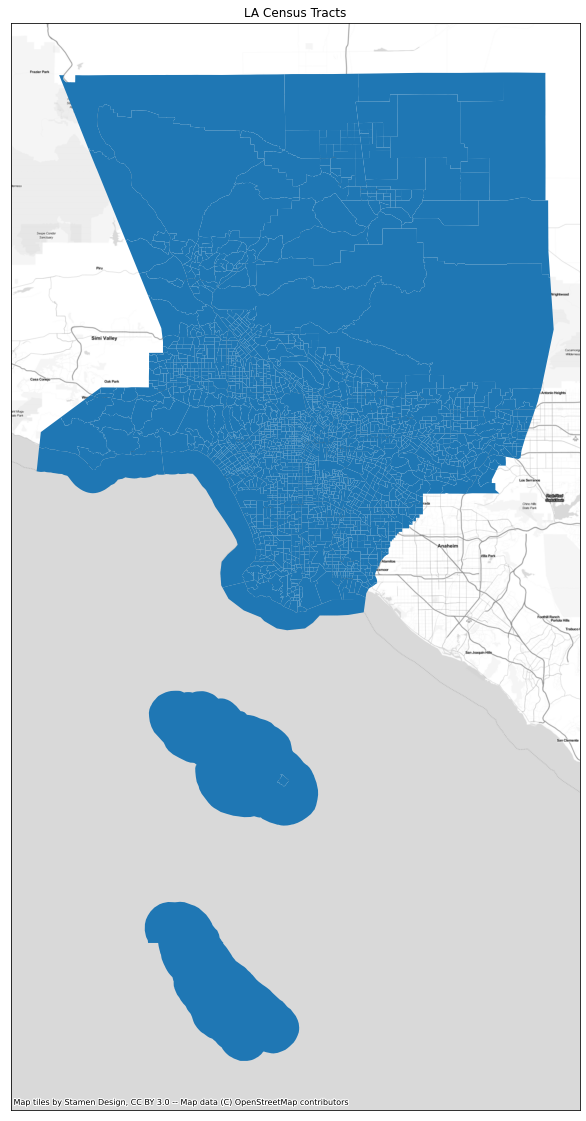

In [55]:
import matplotlib.pyplot as plt
import contextily as ctx

%matplotlib inline

fig, ax=plt.subplots(figsize=(20,20))

joinedtractsgdf.plot(ax=ax, legend=True)

plt.title('LA Census Tracts')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite,zoom=11)

ax.set_xticks([])
ax.set_yticks([])

Next, we will join the tract level information to the parcel scale, and generate the relevant proximity metrics.

In [56]:
parcelsgdf = gpd.GeoDataFrame(parcelsdf, geometry=gpd.points_from_xy(parcelsdf.center_lon, parcelsdf.center_lat))

In [57]:
parcelsgdf = parcelsgdf.set_crs("EPSG:4326")

parcelsgdf = parcelsgdf.to_crs("EPSG:3857")

print(parcelsgdf.crs)

EPSG:3857


We join parcelsgdf, the dataframe that includes all parcels in LA County, with joinedtractsgdf, the dataframe that contains demographic data from 2014 to 2019. This generates a dataframe where each parcel is matched with the demographic characteristics of its census tract.

In [58]:
sparcelsgdf = gpd.sjoin(parcelsgdf, joinedtractsgdf, how="left", op='intersects',rsuffix="_tract")
sparcelsgdf.head()

,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,change_part_rented_14_19,change_part_white_14_19,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19
0,5,-118.434714,NaN,NaN,1961.0,Residential,NaN,4357-015-017,3,0,...,2.589266,7.468089,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295
1,7,-118.509913,NaN,NaN,1948.0,Residential,NaN,2690-001-025,3,0,...,-2.251442,-6.802456,0.101599,11.381757,-2.240775,-4.682100,-4.108205,-7.347608,3.197127,1.985045
2,8,-118.434041,NaN,NaN,1981.0,Residential,NaN,4357-009-014,4,0,...,2.589266,7.468089,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295
3,21,-118.437185,NaN,NaN,1926.0,Residential,NaN,4357-011-006,7,0,...,2.589266,7.468089,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295
4,44,-118.511595,NaN,NaN,1952.0,Residential,NaN,2768-018-013,4,0,...,-2.251442,-6.802456,0.101599,11.381757,-2.240775,-4.682100,-4.108205,-7.347608,3.197127,1.985045


In [59]:
sparcelsgdf.columns

Index(['fid', 'center_lon', 'yearbuilt5', 'yearbuilt4', 'yearbuilt1',
       'usetype', 'yearbuilt2', 'apn', 'bedrooms1', 'bedrooms2',
       ...
       'change_part_rented_14_19', 'change_part_white_14_19',
       'change_part_black_14_19', 'change_part_latx_14_19',
       'change_part_college_14_19', 'change_part_unemployed_14_19',
       'change_part_hh_kids_14_19', 'change_part_female_head_14_19',
       'change_part_poverty_14_19', 'change_part_vacant_14_19'],
      dtype='object', length=150)

Earlier in the notebook, we created dataframes for all parcels built between 2014 and 2019, and all parcels sold between 2014 and 2019. Now, we convert those into geodataframes.

In [63]:
built_14_19gdf=gpd.GeoDataFrame(built_14_19df, geometry=gpd.points_from_xy(built_14_19df.center_lon, built_14_19df.center_lat))
sold_14_19gdf=gpd.GeoDataFrame(sold_14_19df, geometry=gpd.points_from_xy(sold_14_19df.center_lon, sold_14_19df.center_lat))

built_14_19gdf = built_14_19gdf.set_crs("EPSG:4326")
built_14_19gdf = built_14_19gdf.to_crs("EPSG:3857")

sold_14_19gdf = sold_14_19gdf.set_crs("EPSG:4326")
sold_14_19gdf = sold_14_19gdf.to_crs("EPSG:3857")



In [ ]:
sparcelsgdf1=sparcelsgdf[pd.isna(sparcelsgdf['hh_total_2019'])]
print(len(sparcelsgdf1))

In order to identify proximity to high rent tracts and fast increasing rent tracts, we identified the 75th percentile value for 2019 rents and change of rents 2014-2019 to create new layers for a distance analysis. We called tracts in the 75th percentile highrenttractsgdf and highchangetractsgdf, respectively.

In [66]:
joinedtractsgdf['median_rent_2019'].describe()

count    2346.000000
mean     1609.482517
std       516.016102
min       292.000000
25%      1237.250000
50%      1472.000000
75%      1821.750000
max      3501.000000
Name: median_rent_2019, dtype: float64

In [67]:
highrenttractsgdf=joinedtractsgdf[joinedtractsgdf['median_rent_2019']>=1821.750000]

In [68]:
joinedtractsgdf['change_rent_14_19'].describe()

count    2346.000000
mean      281.770469
std       305.122808
min     -1399.000000
25%       135.000000
50%       235.000000
75%       355.000000
max      2543.000000
Name: change_rent_14_19, dtype: float64

In [88]:
highchangetractsgdf=joinedtractsgdf[joinedtractsgdf['change_rent_14_19']>=355.00]

In the next few cells, we calculated the percentage of parcels that were bought and sold in each tract, by joining the built and sold gdfs to joinedtractsgdf (to get tract info), then grouping by tract to count the number of parcels bought and sold.

In [70]:
built_14_19gdf.head(5)

,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,bedrooms_total,bathrooms_total,sqft_total,yearbuilt_avg,built_to_land,estimated_density_per_acre,last_sold_date,sold_14_19,built_14_19,geometry
354,28829,-118.173406,NaN,NaN,2016.0,Residential,NaN,5307-010-003,5,0,...,5,4,2527,2016,0.179037,3.086206,2008-09-09,0,1,POINT (-13155003.402 4041098.226)
1503,33479,-118.199631,NaN,NaN,2017.0,Residential,NaN,5209-003-011,5,0,...,5,3,2176,2017,0.237265,4.749654,2017-11-08,1,1,POINT (-13157922.745 4039741.592)
1759,34442,-118.199179,NaN,NaN,2017.0,Residential,NaN,5305-013-006,3,0,...,3,2,1282,2017,0.230104,7.818516,2013-11-05,0,1,POINT (-13157872.368 4040087.257)
1779,34529,-118.184365,NaN,NaN,2016.0,Residential,NaN,5301-012-025,4,0,...,4,3,1961,2016,0.349691,7.767735,2016-09-26,1,1,POINT (-13156223.291 4042626.307)
2078,36038,-118.197477,NaN,NaN,2015.0,Residential,NaN,5209-007-038,4,0,...,4,3,1915,2015,0.306273,6.966700,2016-10-07,1,1,POINT (-13157682.987 4039748.564)


In [71]:
joinedtractsbuilt = gpd.sjoin(built_14_19gdf, joinedtractsgdf, how="left", op='intersects')
joinedtractsbuilt.head()

,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,change_part_rented_14_19,change_part_white_14_19,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19
354,28829,-118.173406,NaN,NaN,2016.0,Residential,NaN,5307-010-003,5,0,...,-3.659969,2.966994,0.461657,-9.515362,-7.518334,-9.773376,-18.699524,5.478259,4.901542,6.430797
1503,33479,-118.199631,NaN,NaN,2017.0,Residential,NaN,5209-003-011,5,0,...,-6.393546,-3.246582,-2.303898,3.509699,-5.381844,-1.466173,5.242700,1.784626,-3.257410,-2.135031
1759,34442,-118.199179,NaN,NaN,2017.0,Residential,NaN,5305-013-006,3,0,...,-2.777957,1.760069,0.868011,-7.776983,-7.375104,-4.459691,-8.782604,-0.003998,-17.699488,-4.934777
1779,34529,-118.184365,NaN,NaN,2016.0,Residential,NaN,5301-012-025,4,0,...,5.713262,2.179682,2.315482,-5.041721,5.023246,-2.101297,-6.852643,3.858948,1.136401,3.470012
2078,36038,-118.197477,NaN,NaN,2015.0,Residential,NaN,5209-007-038,4,0,...,-6.393546,-3.246582,-2.303898,3.509699,-5.381844,-1.466173,5.242700,1.784626,-3.257410,-2.135031


In [72]:
joinedtractssold = gpd.sjoin(sold_14_19gdf, joinedtractsgdf, how="left", op='intersects')
joinedtractssold.head()

,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,change_part_rented_14_19,change_part_white_14_19,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19
2,8,-118.434041,NaN,NaN,1981.0,Residential,NaN,4357-009-014,4,0,...,2.589266,7.468089,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295
21,25489,-118.214994,NaN,NaN,1895.0,Residential,NaN,5204-010-004,2,0,...,-4.680476,0.497439,-0.022188,0.567481,-0.606698,-4.325974,9.819669,-2.371913,-8.208570,1.671086
23,25512,-118.214505,NaN,NaN,1913.0,Residential,NaN,5204-009-016,1,0,...,-4.680476,0.497439,-0.022188,0.567481,-0.606698,-4.325974,9.819669,-2.371913,-8.208570,1.671086
24,25519,-118.215087,NaN,NaN,1964.0,Residential,1906.0,5204-009-023,1,2,...,-4.680476,0.497439,-0.022188,0.567481,-0.606698,-4.325974,9.819669,-2.371913,-8.208570,1.671086
30,25721,-118.214634,NaN,NaN,1912.0,Commercial,NaN,5204-011-001,0,0,...,-4.680476,0.497439,-0.022188,0.567481,-0.606698,-4.325974,9.819669,-2.371913,-8.208570,1.671086


In [73]:
built1419 = joinedtractsbuilt.groupby('tract')['built_14_19'].apply(lambda x: x[x == True].count())

In [74]:
sold1419 = joinedtractssold.groupby('tract')['sold_14_19'].apply(lambda x: x[x == True].count())

In [75]:
joinedtractsgdf = joinedtractsgdf.set_index('tract')
joinedtractsgdf

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,change_part_rented_14_19,change_part_white_14_19,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19
tract,,,,,,,,,,,,,,,,,,,,,
670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,1.443809,-3.718790,0.192322,-1.637933,-5.791852,-0.812248,8.077523,-13.988090,2.281108,-2.105246
670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,-1.432697,-9.857417,-0.423299,8.713178,-2.741789,4.805957,-2.988459,-10.747972,-4.587828,1.399717
670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,-0.130278,-2.570496,-2.020357,5.232051,-0.704632,-3.139492,1.525131,-7.535231,3.033725,-1.990881
293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,1.315153,3.253112,-8.413734,3.519634,0.128748,-8.818432,-24.348903,5.693507,7.817250,-2.886559
296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,0.707756,-3.125443,8.092568,-12.343961,-5.957872,-2.026725,7.621096,3.439867,6.098741,-6.645230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400404,06037400404,"POLYGON ((-13118649.000 4052670.470, -13118599...",4268.0,2642.0,0.0,821.0,4268.0,614.0,1403.0,428.0,...,-2.185690,-17.431568,-2.135476,8.880263,2.372952,-0.506049,-7.200035,-9.471506,5.782051,-0.985215
400403,06037400403,"POLYGON ((-13114748.360 4045673.350, -13114745...",3906.0,1960.0,71.0,1375.0,3906.0,631.0,1292.0,367.0,...,-6.476404,1.614676,-6.047181,4.924810,-10.196791,-2.162224,-5.563354,-4.617381,6.632169,0.648644
401603,06037401603,"POLYGON ((-13111959.810 4043084.600, -13111939...",2951.0,1579.0,122.0,1053.0,2951.0,706.0,1300.0,234.0,...,-0.607874,-14.004154,2.761436,12.099574,-7.040308,-7.758675,-1.696970,5.057497,-9.579609,-5.838286


In [76]:
aggDf = pd.DataFrame({'n_built1419': built1419, 'n_sold1419': sold1419})

In [77]:
joinedbuiltsold = pd.merge(joinedtractsgdf,aggDf, how='left', on='tract')
joinedbuiltsold

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19,n_built1419,n_sold1419
tract,,,,,,,,,,,,,,,,,,,,,
670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,0.192322,-1.637933,-5.791852,-0.812248,8.077523,-13.988090,2.281108,-2.105246,NaN,NaN
670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,-0.423299,8.713178,-2.741789,4.805957,-2.988459,-10.747972,-4.587828,1.399717,NaN,NaN
670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,-2.020357,5.232051,-0.704632,-3.139492,1.525131,-7.535231,3.033725,-1.990881,NaN,6.0
293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,-8.413734,3.519634,0.128748,-8.818432,-24.348903,5.693507,7.817250,-2.886559,NaN,93.0
296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,8.092568,-12.343961,-5.957872,-2.026725,7.621096,3.439867,6.098741,-6.645230,44.0,474.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400404,06037400404,"POLYGON ((-13118649.000 4052670.470, -13118599...",4268.0,2642.0,0.0,821.0,4268.0,614.0,1403.0,428.0,...,-2.135476,8.880263,2.372952,-0.506049,-7.200035,-9.471506,5.782051,-0.985215,NaN,NaN
400403,06037400403,"POLYGON ((-13114748.360 4045673.350, -13114745...",3906.0,1960.0,71.0,1375.0,3906.0,631.0,1292.0,367.0,...,-6.047181,4.924810,-10.196791,-2.162224,-5.563354,-4.617381,6.632169,0.648644,NaN,NaN
401603,06037401603,"POLYGON ((-13111959.810 4043084.600, -13111939...",2951.0,1579.0,122.0,1053.0,2951.0,706.0,1300.0,234.0,...,2.761436,12.099574,-7.040308,-7.758675,-1.696970,5.057497,-9.579609,-5.838286,NaN,NaN


In [78]:
totalparcels = sparcelsgdf.groupby('tract').size()
totalparcels

tract
101110    1221
101122    1328
101210     741
101220     762
101300    1537
          ... 
980023       3
980024      75
980026      12
980028       8
980031       1
Length: 1000, dtype: int64

In [79]:
joinedbuiltsold['totalparcels'] = totalparcels
joinedbuiltsold.head(5)

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19,n_built1419,n_sold1419,totalparcels
tract,,,,,,,,,,,,,,,,,,,,,
670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,-1.637933,-5.791852,-0.812248,8.077523,-13.988090,2.281108,-2.105246,NaN,NaN,NaN
670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,8.713178,-2.741789,4.805957,-2.988459,-10.747972,-4.587828,1.399717,NaN,NaN,NaN
670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,5.232051,-0.704632,-3.139492,1.525131,-7.535231,3.033725,-1.990881,NaN,6.0,23.0
293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,3.519634,0.128748,-8.818432,-24.348903,5.693507,7.817250,-2.886559,NaN,93.0,412.0
296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,-12.343961,-5.957872,-2.026725,7.621096,3.439867,6.098741,-6.645230,44.0,474.0,1515.0


With these new parcel counts, we created a new gdf that includes tract info, associated demographic data, and counts and rates of parcels bought and sold.

In [80]:
joinedbuiltsold['pctbuilt'] = joinedbuiltsold['n_built1419']/joinedbuiltsold['totalparcels']*100
joinedbuiltsold['pctsold'] = joinedbuiltsold['n_sold1419']/joinedbuiltsold['totalparcels']*100
joinedbuiltsold.head(5)

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19,n_built1419,n_sold1419,totalparcels,pctbuilt,pctsold
tract,,,,,,,,,,,,,,,,,,,,,
670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,-0.812248,8.077523,-13.988090,2.281108,-2.105246,NaN,NaN,NaN,NaN,NaN
670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,4.805957,-2.988459,-10.747972,-4.587828,1.399717,NaN,NaN,NaN,NaN,NaN
670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,-3.139492,1.525131,-7.535231,3.033725,-1.990881,NaN,6.0,23.0,NaN,26.086957
293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,-8.818432,-24.348903,5.693507,7.817250,-2.886559,NaN,93.0,412.0,NaN,22.572816
296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,-2.026725,7.621096,3.439867,6.098741,-6.645230,44.0,474.0,1515.0,2.90429,31.287129


In [81]:
joinedbuiltsold = joinedbuiltsold.fillna(0)
joinedbuiltsold.head(5)

,GEOID,geometry,total_pop_2019,white_2019,black_2019,latx_2019,hh_total_2019,hh_female_head_2019,hh_kids_all_2019,hh_kids_yes_2019,...,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19,n_built1419,n_sold1419,totalparcels,pctbuilt,pctsold
tract,,,,,,,,,,,,,,,,,,,,,
670403,06037670403,"POLYGON ((-13177840.910 3998757.250, -13177839...",2733.0,1422.0,26.0,116.0,2733.0,351.0,992.0,364.0,...,-0.812248,8.077523,-13.988090,2.281108,-2.105246,0.0,0.0,0.0,0.00000,0.000000
670202,06037670202,"POLYGON ((-13177176.670 4000044.060, -13177164...",2637.0,1473.0,25.0,481.0,2637.0,397.0,889.0,319.0,...,4.805957,-2.988459,-10.747972,-4.587828,1.399717,0.0,0.0,0.0,0.00000,0.000000
670701,06037670701,"POLYGON ((-13171166.080 3997280.030, -13171138...",7185.0,3592.0,29.0,1841.0,7185.0,1101.0,2497.0,749.0,...,-3.139492,1.525131,-7.535231,3.033725,-1.990881,0.0,6.0,23.0,0.00000,26.086957
293307,06037293307,"POLYGON ((-13170065.910 4000308.450, -13170065...",2284.0,259.0,183.0,1384.0,2284.0,431.0,914.0,223.0,...,-8.818432,-24.348903,5.693507,7.817250,-2.886559,0.0,93.0,412.0,0.00000,22.572816
296300,06037296300,"POLYGON ((-13170120.120 3995289.290, -13170111...",5027.0,2082.0,458.0,1171.0,5027.0,1030.0,2054.0,627.0,...,-2.026725,7.621096,3.439867,6.098741,-6.645230,44.0,474.0,1515.0,2.90429,31.287129


Next, we wanted to calculate the distance of each parcel to the nearest high rent and high rent increase tracts. We calculate this because the literature has suggested that rising rents and housing development has a spillover effect on nearby buildings, where landlords may raise rents, or use the Ellis Act to convert apartments to condoes, if they see indications of increased neighborhood prices. In the next few cells, we use a function to calculate the distance between each parcel in sparcelsgdf to its nearest high rent tract, and its nearest high rent increase tract. Since sparcelsgdf has over 750k rows, each cell takes several hours to run.

In [82]:
sparcelsgdf.set_index('ain', inplace=True)

In [83]:
def get_closest_tract(row):
    parcel = row.geometry
    distances = highrenttractsgdf.distance(parcel)
    min_dist = distances.min()
    return pd.Series([min_dist])

sparcelsgdf[['dist_to_nearest_highrenttract']] = sparcelsgdf.apply(get_closest_tract, axis=1)
sparcelsgdf.head()


,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,change_part_white_14_19,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19,dist_to_nearest_highrenttract
ain,,,,,,,,,,,,,,,,,,,,,
4357015017,5,-118.434714,NaN,NaN,1961.0,Residential,NaN,4357-015-017,3,0,...,7.468089,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295,507.232099
2690001025,7,-118.509913,NaN,NaN,1948.0,Residential,NaN,2690-001-025,3,0,...,-6.802456,0.101599,11.381757,-2.240775,-4.682100,-4.108205,-7.347608,3.197127,1.985045,1535.197835
4357009014,8,-118.434041,NaN,NaN,1981.0,Residential,NaN,4357-009-014,4,0,...,7.468089,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295,399.916938
4357011006,21,-118.437185,NaN,NaN,1926.0,Residential,NaN,4357-011-006,7,0,...,7.468089,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295,259.478126
2768018013,44,-118.511595,NaN,NaN,1952.0,Residential,NaN,2768-018-013,4,0,...,-6.802456,0.101599,11.381757,-2.240775,-4.682100,-4.108205,-7.347608,3.197127,1.985045,1621.702540


In [89]:
def get_closest_tract_2(row):
    parcel2 = row.geometry
    distances2 = highchangetractsgdf.distance(parcel2)
    min_dist2 = distances2.min()
    return pd.Series([min_dist2])

sparcelsgdf[['dist_to_nearest_highchangetract']] = sparcelsgdf.apply(get_closest_tract_2, axis=1)
sparcelsgdf.head()


,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,change_part_black_14_19,change_part_latx_14_19,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19,dist_to_nearest_highrenttract,dist_to_nearest_highchangetract
ain,,,,,,,,,,,,,,,,,,,,,
4357015017,5,-118.434714,NaN,NaN,1961.0,Residential,NaN,4357-015-017,3,0,...,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295,507.232099,622.356895
2690001025,7,-118.509913,NaN,NaN,1948.0,Residential,NaN,2690-001-025,3,0,...,0.101599,11.381757,-2.240775,-4.682100,-4.108205,-7.347608,3.197127,1.985045,1535.197835,1535.197835
4357009014,8,-118.434041,NaN,NaN,1981.0,Residential,NaN,4357-009-014,4,0,...,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295,399.916938,758.811482
4357011006,21,-118.437185,NaN,NaN,1926.0,Residential,NaN,4357-011-006,7,0,...,-0.707327,-7.030906,-0.307606,-1.943035,10.173139,-7.908945,3.395515,7.038295,259.478126,259.478126
2768018013,44,-118.511595,NaN,NaN,1952.0,Residential,NaN,2768-018-013,4,0,...,0.101599,11.381757,-2.240775,-4.682100,-4.108205,-7.347608,3.197127,1.985045,1621.702540,1753.438578


Now we want to create our datasets for the statistical and clustering tests. One dataset will include Ellis properties with the parcel information joined, and another will include all parcels, with an indication of the Ellis status.

In [142]:
joinedbuiltsold1=joinedbuiltsold[['n_built1419','n_sold1419','totalparcels','pctbuilt','pctsold']]

In [144]:
sparcelsgdf=sparcelsgdf.join(joinedbuiltsold, on='tract', how='left',rsuffix='_builtsold')
sparcelsgdf.head()

,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,change_part_unemployed_14_19_builtsold,change_part_hh_kids_14_19_builtsold,change_part_female_head_14_19_builtsold,change_part_poverty_14_19_builtsold,change_part_vacant_14_19_builtsold,n_built1419_builtsold,n_sold1419_builtsold,totalparcels_builtsold,pctbuilt_builtsold,pctsold_builtsold
ain,,,,,,,,,,,,,,,,,,,,,
4357015017,5,-118.434714,NaN,NaN,1961.0,Residential,NaN,4357-015-017,3,0,...,-1.943035,10.173139,-7.908945,3.395515,7.038295,12.0,373.0,1782.0,0.673401,20.931538
2690001025,7,-118.509913,NaN,NaN,1948.0,Residential,NaN,2690-001-025,3,0,...,-4.682100,-4.108205,-7.347608,3.197127,1.985045,6.0,311.0,1690.0,0.355030,18.402367
4357009014,8,-118.434041,NaN,NaN,1981.0,Residential,NaN,4357-009-014,4,0,...,-1.943035,10.173139,-7.908945,3.395515,7.038295,12.0,373.0,1782.0,0.673401,20.931538
4357011006,21,-118.437185,NaN,NaN,1926.0,Residential,NaN,4357-011-006,7,0,...,-1.943035,10.173139,-7.908945,3.395515,7.038295,12.0,373.0,1782.0,0.673401,20.931538
2768018013,44,-118.511595,NaN,NaN,1952.0,Residential,NaN,2768-018-013,4,0,...,-4.682100,-4.108205,-7.347608,3.197127,1.985045,6.0,311.0,1690.0,0.355030,18.402367


We generated studyellisdf earlier in this notebook - it's the subset of Ellis Act uses that occurred between 2014 and 2019. By joining studyellisdf to sparcelsgdf, we capture the all the parcel characteristics for each parcel that was Ellis-ed during that time frame.

In [90]:
studyellisdf.dtypes

application_received            object
application_year                 int64
council_district                 int64
address                         object
city                            object
zip                            float64
units_withdrawn                  int64
replacement_unit               float64
yearbuilt                      float64
units                          float64
sqftmain                       float64
center_lat                     float64
center_lon                     float64
geometry                        object
application_date        datetime64[ns]
dtype: object

In [145]:
#studyellisdf=studyellisdf.set_index('ain')
#sparcelgsdf=sparcelsgdf.set_index('ain')

parcelsjoindf=sparcelsgdf.join(studyellisdf, on='ain', how='left', rsuffix='_ellis')

parcelsjoindf.head()

,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,zip,units_withdrawn,replacement_unit,yearbuilt,units,sqftmain,center_lat_ellis,center_lon_ellis,geometry_ellis,application_date
ain,,,,,,,,,,,,,,,,,,,,,
4357015017,5,-118.434714,NaN,NaN,1961.0,Residential,NaN,4357-015-017,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2690001025,7,-118.509913,NaN,NaN,1948.0,Residential,NaN,2690-001-025,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4357009014,8,-118.434041,NaN,NaN,1981.0,Residential,NaN,4357-009-014,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4357011006,21,-118.437185,NaN,NaN,1926.0,Residential,NaN,4357-011-006,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2768018013,44,-118.511595,NaN,NaN,1952.0,Residential,NaN,2768-018-013,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [146]:
parcelsjoindf1=parcelsjoindf[pd.isna(parcelsjoindf['units_withdrawn'])]
print(len(parcelsjoindf1))

703987


In [147]:
parcelsjoindf2=parcelsjoindf[pd.notna(parcelsjoindf['units_withdrawn'])]
print(len(parcelsjoindf2))

1249


In [148]:
parcelsjoindf3=parcelsjoindf[parcelsjoindf['units_total']>1]

parcelsjoindf4=parcelsjoindf3[parcelsjoindf3['yearbuilt_avg']<1979]

def process_ellis_status(parcelsjoindf4):
    if pd.notna(parcelsjoindf4['units_withdrawn']):
        return 1
    else: 
        return 0
    
parcelsjoindf4['ellis_status']=parcelsjoindf4.apply(process_ellis_status, axis=1)

print(parcelsjoindf4.ellis_status.value_counts())
print(len(parcelsjoindf4))

0    99041
1     1099
Name: ellis_status, dtype: int64
100140


/Applications/anaconda3/envs/UP299/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [149]:
parcelsjoindf4.to_csv('/Users/alexanderferrer/Documents/GitHub/UP229_Ellis/parcels_finaldf.csv')

In [150]:
parcelsjoindf5=parcelsjoindf4[pd.notna(parcelsjoindf4['units_withdrawn'])]

print(len(parcelsjoindf5))

1099


In [151]:
parcelsjoindf4.head()

,fid,center_lon,yearbuilt5,yearbuilt4,yearbuilt1,usetype,yearbuilt2,apn,bedrooms1,bedrooms2,...,units_withdrawn,replacement_unit,yearbuilt,units,sqftmain,center_lat_ellis,center_lon_ellis,geometry_ellis,application_date,ellis_status
ain,,,,,,,,,,,,,,,,,,,,,
5204008002,25303,-118.215784,NaN,NaN,1887.0,Residential,2003.0,5204-008-002,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
5204008023,25423,-118.216276,NaN,NaN,1902.0,Residential,1923.0,5204-008-023,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
5204009003,25424,-118.215121,NaN,NaN,1908.0,Residential,NaN,5204-009-003,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
5204008013,25459,-118.216663,NaN,NaN,1888.0,Residential,1979.0,5204-008-013,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
5204010015,25498,-118.214820,NaN,NaN,1906.0,Residential,NaN,5204-010-015,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0


In [129]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(list(parcelsjoindf4.columns))

['index', 'ain', 'fid', 'center_lon', 'yearbuilt5', 'yearbuilt4', 'yearbuilt1', 'usetype', 'yearbuilt2', 'apn', 'bedrooms1', 'bedrooms2', 'bedrooms3', 'bedrooms4', 'bedrooms5', 'usedescription', 'mailaddress', 'sqftmain2', 'sqftmain3', 'sqftmain1', 'sqftmain4', 'sqftmain5', 'mailcity', 'units1', 'units3', 'units2', 'units5', 'units4', 'ownerfullname', 'agencyname', 'bathrooms5', 'bathrooms4', 'bathrooms1', 'bathrooms3', 'bathrooms2', 'situsfulladdress', 'shape.starea()', 'shape.stlength()', 'yearbuilt3', 'center_lat', 'ls1_sale_amount', 'ls1_sale_date', 'ls2_sale_amount', 'ls2_sale_date', 'units_total', 'bedrooms_total', 'bathrooms_total', 'sqft_total', 'yearbuilt_avg', 'built_to_land', 'estimated_density_per_acre', 'last_sold_date', 'sold_14_19', 'built_14_19', 'landlord_type', 'n_ll_properties', 'n_ll_units', 'landlord_iscorp', 'geometry', 'index__tract', 'tract', 'GEOID', 'total_pop_2019', 'white_2019', 'black_2019', 'latx_2019', 'hh_total_2019', 'hh_female_head_2019', 'hh_kids_all_

In [171]:
independent_vars_log= ['units_total','sqft_total','yearbuilt_avg', 'built_to_land', 'estimated_density_per_acre',
                       'median_income_2019','median_rent_2019','median_value_2019','part_black_2019',
                       'part_latx_2019', 'part_white_2019', 'part_female_head_2019', 'part_hh_kids_2019',
                       'part_rented_2019', 'part_unemployed_2019', 'part_poverty_2019', 'part_vacant_2019',
                       'part_college_2019','change_rent_14_19', 'change_value_14_19', 'change_part_rented_14_19',
                       'change_part_white_14_19', 'change_part_black_14_19', 'change_part_latx_14_19',
                       'change_part_college_14_19', 'change_part_unemployed_14_19', 'change_part_hh_kids_14_19',
                       'change_part_female_head_14_19', 'change_part_poverty_14_19', 'change_part_vacant_14_19',
                       'dist_to_nearest_highrenttract', 'dist_to_nearest_highchangetract','pctbuilt','pctsold' ]

independent_vars_lin= ['units_total','sqft_total','yearbuilt_avg', 'built_to_land', 'estimated_density_per_acre',
                       'n_ll_properties', 'n_ll_units', 'landlord_iscorp','median_income_2019','median_rent_2019',
                       'median_value_2019','part_black_2019',
                       'part_latx_2019', 'part_white_2019', 'part_female_head_2019', 'part_hh_kids_2019',
                       'part_rented_2019', 'part_unemployed_2019', 'part_poverty_2019', 'part_vacant_2019',
                       'part_college_2019','change_rent_14_19', 'change_value_14_19', 'change_part_rented_14_19',
                       'change_part_white_14_19', 'change_part_black_14_19', 'change_part_latx_14_19',
                       'change_part_college_14_19', 'change_part_unemployed_14_19', 'change_part_hh_kids_14_19',
                       'change_part_female_head_14_19', 'change_part_poverty_14_19', 'change_part_vacant_14_19',
                       'dist_to_nearest_highrenttract', 'dist_to_nearest_highchangetract','pctbuilt','pctsold']

In [193]:
parcelsjoindf4[['units_total','sqft_total','yearbuilt_avg', 'built_to_land', 'estimated_density_per_acre',
                       'median_income_2019','median_rent_2019','median_value_2019','part_black_2019',
                       'part_latx_2019', 'part_white_2019', 'part_female_head_2019', 'part_hh_kids_2019',
                       'part_rented_2019', 'part_unemployed_2019', 'part_poverty_2019', 'part_vacant_2019',
                       'part_college_2019','change_rent_14_19', 'change_value_14_19', 'change_part_rented_14_19',
                       'change_part_white_14_19', 'change_part_black_14_19', 'change_part_latx_14_19',
                       'change_part_college_14_19', 'change_part_unemployed_14_19', 'change_part_hh_kids_14_19',
                       'change_part_female_head_14_19', 'change_part_poverty_14_19', 'change_part_vacant_14_19',
                       'dist_to_nearest_highrenttract', 'dist_to_nearest_highchangetract','pctbuilt','pctsold' ]].agg(["count","mean","std"])

,units_total,sqft_total,yearbuilt_avg,built_to_land,estimated_density_per_acre,median_income_2019,median_rent_2019,median_value_2019,part_black_2019,part_latx_2019,...,change_part_college_14_19,change_part_unemployed_14_19,change_part_hh_kids_14_19,change_part_female_head_14_19,change_part_poverty_14_19,change_part_vacant_14_19,dist_to_nearest_highrenttract,dist_to_nearest_highchangetract,pctbuilt,pctsold
count,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,...,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000,100140.000000
mean,6.232594,5120.825335,1937.454484,0.831379,42.927146,59434.744357,1429.465289,679136.409452,10.822712,53.120573,...,-0.752131,-5.665440,-3.821015,5.982941,-8.418742,0.120306,1775.176472,804.077293,1.158114,20.426186
std,15.753543,13646.175242,19.017924,91.514775,4404.880948,26459.086623,377.260626,335927.978379,13.787810,27.802960,...,6.147824,4.772338,7.126743,5.787951,11.844969,5.028011,1880.241243,895.771115,1.949679,4.211663


In [153]:
ellisjoindf = studyellisdf.join(sparcelsgdf, on='ain', how='left', rsuffix='parcel')

ellisjoindf.head()

,application_received,application_year,council_district,address,city,zip,units_withdrawn,replacement_unit,yearbuilt,units,...,change_part_unemployed_14_19_builtsold,change_part_hh_kids_14_19_builtsold,change_part_female_head_14_19_builtsold,change_part_poverty_14_19_builtsold,change_part_vacant_14_19_builtsold,n_built1419_builtsold,n_sold1419_builtsold,totalparcels_builtsold,pctbuilt_builtsold,pctsold_builtsold
ain,,,,,,,,,,,,,,,,,,,,,
2040031029,11/6/19,2019,3,22729 W DEL VALLE ST,LOS ANGELES,91364.0,3,0.0,1955.0,3.0,...,0.305567,-1.733895,5.616767,1.231336,-0.174984,1.0,340.0,1481.0,0.067522,22.957461
2040031030,12/4/19,2019,3,22727 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,...,0.305567,-1.733895,5.616767,1.231336,-0.174984,1.0,340.0,1481.0,0.067522,22.957461
2040033033,2/10/16,2016,3,22431 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,...,0.305567,-1.733895,5.616767,1.231336,-0.174984,1.0,340.0,1481.0,0.067522,22.957461
2111025021,3/16/16,2016,3,7118 N JORDAN AVE,CANOGA PARK,91303.0,2,9.0,1947.0,2.0,...,-5.629971,-0.316344,3.730233,-16.085304,-1.814039,4.0,100.0,538.0,0.743494,18.587361
2112024012,8/13/15,2015,3,7310 N ETON AVE,LOS ANGELES,91303.0,2,0.0,1961.0,2.0,...,2.101883,2.548087,-0.083979,9.355085,-0.826249,1.0,36.0,212.0,0.471698,16.981132


With our Ellis datset, we will also want to create a new field that takes the difference between the filing date and the last sale date for the property. Thereby we can filter out negative diffs (landlord no longer owns property) and study the difference in neighborhood conditions in changing filing times.

In [154]:
ellisjoindf['time_to_file']=ellisjoindf['application_date']-ellisjoindf['last_sold_date']
ellisjoindf['time_to_file']=ellisjoindf['time_to_file'].astype('timedelta64[D]')

In [155]:
ellisjoindf.head()

,application_received,application_year,council_district,address,city,zip,units_withdrawn,replacement_unit,yearbuilt,units,...,change_part_hh_kids_14_19_builtsold,change_part_female_head_14_19_builtsold,change_part_poverty_14_19_builtsold,change_part_vacant_14_19_builtsold,n_built1419_builtsold,n_sold1419_builtsold,totalparcels_builtsold,pctbuilt_builtsold,pctsold_builtsold,time_to_file
ain,,,,,,,,,,,,,,,,,,,,,
2040031029,11/6/19,2019,3,22729 W DEL VALLE ST,LOS ANGELES,91364.0,3,0.0,1955.0,3.0,...,-1.733895,5.616767,1.231336,-0.174984,1.0,340.0,1481.0,0.067522,22.957461,678.0
2040031030,12/4/19,2019,3,22727 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,...,-1.733895,5.616767,1.231336,-0.174984,1.0,340.0,1481.0,0.067522,22.957461,706.0
2040033033,2/10/16,2016,3,22431 W DEL VALLE ST,WOODLAND HILLS,91364.0,3,0.0,1955.0,3.0,...,-1.733895,5.616767,1.231336,-0.174984,1.0,340.0,1481.0,0.067522,22.957461,-1141.0
2111025021,3/16/16,2016,3,7118 N JORDAN AVE,CANOGA PARK,91303.0,2,9.0,1947.0,2.0,...,-0.316344,3.730233,-16.085304,-1.814039,4.0,100.0,538.0,0.743494,18.587361,495.0
2112024012,8/13/15,2015,3,7310 N ETON AVE,LOS ANGELES,91303.0,2,0.0,1961.0,2.0,...,2.548087,-0.083979,9.355085,-0.826249,1.0,36.0,212.0,0.471698,16.981132,-1191.0


In [156]:
ellisjoindf.dtypes

application_received       object
application_year            int64
council_district            int64
address                    object
city                       object
                           ...   
n_sold1419_builtsold      float64
totalparcels_builtsold    float64
pctbuilt_builtsold        float64
pctsold_builtsold         float64
time_to_file              float64
Length: 359, dtype: object

Now we'll want to check and see to what extent parcels have been built since an Ellis Filing, and to what extent they have been sold since the filing, which will determine whether or not the record can remain in the sample. 

In [157]:
ellisjoindf.yearbuilt_avg.unique()

array([1955., 2017., 1961.,   nan, 1953., 1956., 1926., 1950., 1933.,
       1951., 1952., 1948., 1949., 1924., 1937., 1917., 1923., 1957.,
       1930., 1943., 1940., 1947., 1941., 1925., 1936., 1931., 1932.,
       1938., 1976., 1935., 1942., 1963., 1944., 1954., 2018., 1973.,
       1927., 1921., 1946., 1959., 1971., 1978., 1907., 1966., 1929.,
       1965., 1972., 1960., 1969., 1915., 1928., 1911., 1914., 1922.,
       1919., 2015., 2016., 2019., 1994., 1968., 1958., 1912., 1905.,
       1939., 1934., 1945., 1999., 1962., 1913., 1909., 1920., 1918.,
       1908., 1916., 1910., 1906., 1904., 1901., 1903., 1902., 1890.,
       1895., 1893., 1900., 1885., 1896., 1964., 2013., 1974., 1975.,
       1970.])

In [158]:
print(len(ellisjoindf))

1893


In [159]:
ellisjoindf1=ellisjoindf[ellisjoindf['time_to_file']>-1]
print(len(ellisjoindf1))

940


In [160]:
ellisjoindf2=ellisjoindf1[ellisjoindf1['landlord_type']>0]
print(len(ellisjoindf2))

926


In [161]:
ellisjoindf2.to_csv('/Users/alexanderferrer/Documents/GitHub/UP229_Ellis/ellis_sample_finaldf.csv')